In [333]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import requests
import os
import numpy as np

pd.options.mode.chained_assignment = None
pd.set_option('display.max_rows', 200)

## Fetch Data

In [334]:
standings_ulrs = {
    "Serie A": "http://api.football-data.org/v4/competitions/SA/standings",
    "Bundesliga": "http://api.football-data.org/v4/competitions/BL1/standings",
    "La Liga": "http://api.football-data.org/v4/competitions/PD/standings",
    "Premier League": "http://api.football-data.org/v4/competitions/PL/standings"
}
headers = {"X-Auth-Token": os.getenv('footaball_data_token')}

### Standing

In [335]:
standings = {}

for competition, url in standings_ulrs.items():
    response = requests.get(url, headers=headers)

    data = response.json()
    data = data['standings'][0]['table']
    standing = pd.DataFrame(data)

    # Extract the 'shortName' value from the 'team' dictionary
    standing['team_short_name'] = standing['team'].apply(lambda x: x['shortName'])
    # Drop the 'team' column
    standing.drop(columns=['team'], inplace=True)
    
    n_groups = 3
    standing['team_group'] = standing.position.apply(lambda x: int(((x-1)/(20/n_groups))))
    standing['team_short_name'] = \
                standing['team_short_name']\
                        .replace({
                        'Spezia Calcio':'Spezia',
                        #
                        'Frankfurt':'Ein Frankfurt', 
                        '1. FC Köln': 'FC Koln',
                        'Hertha BSC': 'Hertha', 
                        'Bremen': 'Werder Bremen', 
                        'Schalke': 'Schalke 04', 
                        'Bayern': 'Bayern Munich',
                        #
                        'Barça':'Barcelona', 
                        'Cádiz CF': 'Cadiz', 
                        'Almería': 'Almeria', 
                        'Athletic':'Ath Bilbao', 
                        'Real Betis': 'Betis', 
                        'Espanyol': 'Espanol',
                        'Sevilla FC': 'Sevilla',
                        'Atleti': 'Ath Madrid', 
                        'Real Sociedad':'Sociedad', 
                        'Rayo Vallecano': 'Vallecano',
                        #
                        'Leeds United':'Leeds', 
                        'Leicester City':'Leicester', 
                        'Brighton Hove':'Brighton',
                        'Wolverhampton':'Wolves', 
                        'Nottingham':"Nott'm Forest"
                        })

    standings[competition] = standing

### Match Days

In [336]:
data_url = {
    "Serie A": "https://www.football-data.co.uk/mmz4281/2223/I1.csv",
    "Bundesliga": "https://www.football-data.co.uk/mmz4281/2223/D1.csv",
    "La Liga": "https://www.football-data.co.uk/mmz4281/2223/SP1.csv",
    "Premier League": "https://www.football-data.co.uk/mmz4281/2223/E0.csv"
}

data_paths = {
}

for competition, url in data_url.items():
    response = requests.get(url)
    filename = competition.replace(' ','_') + ".csv"
    file_dir = f"data/raw/{os.getenv('season')}/"
    file_path = f"{file_dir}{filename}"

    if not os.path.exists(file_dir):
        os.makedirs(file_dir)
    with open(file_path, "wb") as f:
        f.write(response.content)
        
    df = pd.read_csv(file_path)
    
    ### Fix MatchDays -----------------
    df.loc[(df.HomeTeam == 'Empoli') & (df.AwayTeam == 'Cremonese'),'Date'] = '12/11/2022'
    #Avoid no breaks
    df.loc[(df.HomeTeam == 'Brentford') & (df.AwayTeam == 'Liverpool'),'Date'] = '03/01/2023'
    df.loc[(df.HomeTeam == 'Villarreal') & (df.AwayTeam == 'Osasuna'),'Date'] = '16/10/2022'
    df.loc[(df.HomeTeam == 'Villarreal') & (df.AwayTeam == 'Vallecano'),'Date'] = '29/01/2023'
    df.loc[(df.HomeTeam == 'Vallecano') & (df.AwayTeam == 'Real Madrid'),'Date'] = '06/11/2022'
    df.loc[(df.HomeTeam == 'Real Madrid') & (df.AwayTeam == 'Elche'),'Date'] = '13/02/2023'
    #Matchday 7
    df.loc[(df.HomeTeam == 'Fulham') & (df.AwayTeam == 'Chelsea'),'Date'] = '10/09/2022'
    df.loc[(df.HomeTeam == 'Crystal Palace') & (df.AwayTeam == 'Man United'),'Date'] = '10/09/2022'
    df.loc[(df.HomeTeam == 'Man City') & (df.AwayTeam == 'Tottenham'),'Date'] = '10/09/2022'
    df.loc[(df.HomeTeam == 'Arsenal') & (df.AwayTeam == 'Everton'),'Date'] = '10/09/2022'
    df.loc[(df.HomeTeam == 'Liverpool') & (df.AwayTeam == 'Wolves'),'Date'] = '10/09/2022'
    df.loc[(df.HomeTeam == 'Southampton') & (df.AwayTeam == 'Brentford'),'Date'] = '10/09/2022'
    df.loc[(df.HomeTeam == 'Leeds') & (df.AwayTeam == "Nott'm Forest"),'Date'] = '10/09/2022'
    df.loc[(df.HomeTeam == 'Bournemouth') & (df.AwayTeam == "Brighton"),'Date'] = '10/09/2022'
    df.loc[(df.HomeTeam == 'Leicester') & (df.AwayTeam == "Aston Villa"),'Date'] = '10/09/2022'
    #Matchday 8
    df.loc[(df.HomeTeam == 'Man United') & (df.AwayTeam == 'Leeds'),'Date'] = '16/09/2022'
    df.loc[(df.HomeTeam == 'Brighton') & (df.AwayTeam == 'Crystal Palace'),'Date'] = '16/09/2022'
    df.loc[(df.HomeTeam == 'Chelsea') & (df.AwayTeam == 'Liverpool'),'Date'] = '16/09/2023'
    #Matchday 12
    df.loc[(df.HomeTeam == 'Arsenal') & (df.AwayTeam == 'Man City'),'Date'] = '19/10/2022'
    #Matchday 17
    df.loc[(df.HomeTeam == 'Betis') & (df.AwayTeam == 'Barcellona'),'Date'] = '13/01/2023'
    df.loc[(df.HomeTeam == 'Real Madrid') & (df.AwayTeam == 'Valencia'),'Date'] = '13/01/2023'
    #Matchday 25
    df.loc[(df.HomeTeam == 'Man United') & (df.AwayTeam == 'Brentford'),'Date'] = '24/02/2023'
    ### Fix MatchDays -----------------
    
    df['datetime'] = pd.to_datetime(df.Date, format='%d/%m/%Y')
    df['year'] = pd.to_datetime(df.Date, format='%d/%m/%Y').dt.year
    df['month'] = pd.to_datetime(df.Date,format='%d/%m/%Y').dt.month
    df['day'] = pd.to_datetime(df.Date,format='%d/%m/%Y').dt.day
    df['week'] = pd.to_datetime(df.Date,format='%d/%m/%Y').dt.isocalendar().week
    df['weekday'] = pd.to_datetime(df.Date,format='%d/%m/%Y').dt.weekday
    
    df = df.sort_values(['year', 'month', 'day'])
    
    # Assign sequential week numbers to blocks of days from Thursday to Wednesday
    giornata = 1
    curr_daytime = None
    for i, row in df.iterrows():
        curr_daytime = row['datetime'] if curr_daytime is None else curr_daytime
        if(curr_daytime is not None):
            if (row['datetime'] - curr_daytime)/ np.timedelta64(1, 'D') > 1:
                giornata+=1
        else:
            giornata+=1
        curr_daytime = row['datetime']
        df.at[i, 'giornata'] = giornata
        
    file_clean_dir = f"data/clean/{os.getenv('season')}/"
    if not os.path.exists(file_clean_dir):
        os.makedirs(file_clean_dir)

    df.to_csv(f"{file_clean_dir}{filename}", index=False)
    data_paths[competition] = f"{file_clean_dir}{filename}"

## Data Preparations

#### Create main dataframe with all leagues

In [337]:
matches_raw_df = None
for competition, data_path in data_paths.items():
    df_ = pd.read_csv(data_paths[competition], index_col=None)
    df_['competition'] = competition
    if(matches_raw_df is None):
        matches_raw_df = df_
    else:
        matches_raw_df = pd.concat([matches_raw_df,df_])

In [338]:
matches_raw_df.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgCAHA,datetime,year,month,day,week,weekday,giornata,competition,Referee
0,I1,13/08/2022,17:30,Milan,Udinese,4,2,H,2,2,...,1.81,2022-08-13,2022,8,13,32,5,1.0,Serie A,NaN
1,I1,13/08/2022,17:30,Sampdoria,Atalanta,0,2,A,0,1,...,1.82,2022-08-13,2022,8,13,32,5,1.0,Serie A,NaN
2,I1,13/08/2022,19:45,Lecce,Inter,1,2,A,0,1,...,1.97,2022-08-13,2022,8,13,32,5,1.0,Serie A,NaN
3,I1,13/08/2022,19:45,Monza,Torino,1,2,A,0,1,...,2.06,2022-08-13,2022,8,13,32,5,1.0,Serie A,NaN
4,I1,14/08/2022,17:30,Fiorentina,Cremonese,3,2,H,2,1,...,1.87,2022-08-14,2022,8,14,32,6,1.0,Serie A,NaN


#### Check matchday number uniqueness

In [339]:
tt1 = df[['HomeTeam','giornata']]
tt1.columns = ['team','giornata']
tt1['value'] = 1
tt2 = df[['AwayTeam','giornata']]
tt2.columns = ['team','giornata']
tt2['value'] = 1
assert (pd.concat([tt1,tt2]).groupby(['team','giornata']).count() > 1).sum()['value'] == 0,\
        'Some teams have the same matchday associated more than once'

In [340]:
s = pd.concat([tt1,tt2]).groupby(['team','giornata']).count().reset_index()
s[s.value > 1]

,team,giornata,value


In [341]:
standings_df = None
for competition, standing in standings.items():
    df_ = standings[competition]
    df_['competition'] = competition
    if(standings_df is None):
        standings_df = df_
    else:
        standings_df = pd.concat([standings_df,df_])
standings_df.to_csv('data/outputs/standings.csv', index=False)
standings_df.head()

,position,playedGames,form,won,draw,lost,points,goalsFor,goalsAgainst,goalDifference,team_short_name,team_group,competition
0,1,29,None,24,2,3,74,66,21,45,Napoli,0,Serie A
1,2,29,None,17,7,5,58,46,20,26,Lazio,0,Serie A
2,3,29,None,16,5,8,53,39,26,13,Roma,0,Serie A
3,4,29,None,15,7,7,52,48,36,12,Milan,0,Serie A
4,5,29,None,16,3,10,51,48,33,15,Inter,0,Serie A


In [342]:
def get_result(row):
    if(row['goal_fatti'] > row['goal_subiti']):
        return 'Win'
    if(row['goal_fatti'] == row['goal_subiti']):
        return 'Draw'
    return 'Loss'

In [343]:
df = matches_raw_df
df_match_home = df
df_match_home['main_team'] = df.HomeTeam
df_match_home['opponent_team'] = df.AwayTeam
df_match_home['goal_fatti'] = df['FTHG']
df_match_home['goal_subiti'] = df['FTAG']
df_match_home['tot_goals'] = df['goal_fatti'] + df['goal_subiti']
df_match_home['no_goal'] = (df['goal_fatti'] == 0) | (df['goal_subiti'] == 0)
df_match_home['goal'] = (df['goal_fatti'] != 0) & (df['goal_subiti'] != 0)
df_match_home['goal_no_goal'] = df_match_home['no_goal'].map({True: 'No Goal', False: 'Goal'})
df_match_home['away_home'] = 'home'
df_match_home['result'] = df_match_home.apply(get_result, axis=1)
df_match_home['team_has_scored'] = df_match_home['goal_fatti'] > 0
df_match_home['team_has_conceded_goal'] = df_match_home['goal_subiti'] > 0
df_match_home = df_match_home[['main_team','opponent_team','goal_fatti', 'no_goal', 'goal', 'tot_goals',\
                               'goal_subiti','away_home','result','team_has_scored','giornata','goal_no_goal',\
                              'team_has_conceded_goal','competition']]

df_match_away = df
df_match_away['main_team'] = df.AwayTeam
df_match_away['opponent_team'] = df.HomeTeam
df_match_away['goal_fatti'] = df['FTAG']
df_match_away['goal_subiti'] = df['FTHG']
df_match_away['tot_goals'] = df['goal_fatti'] + df['goal_subiti']
df_match_away['away_home'] = 'away'
df_match_away['result'] = df_match_away.apply(get_result, axis=1)
df_match_away['team_has_scored'] = df_match_away['goal_fatti'] > 0
df_match_away['team_has_conceded_goal'] = df_match_away['goal_subiti'] > 0
df_match_away['no_goal'] = (df['goal_fatti'] == 0) | (df['goal_subiti'] == 0)
df_match_away['goal'] = (df['goal_fatti'] != 0) & (df['goal_subiti'] != 0)
df_match_away['goal_no_goal'] = df_match_away['no_goal'].map({True: 'No Goal', False: 'Goal'})
df_match_away = df_match_away[['main_team','opponent_team','goal_fatti', 'no_goal', 'goal', 'tot_goals',\
                               'goal_subiti','away_home','result','team_has_scored','giornata','goal_no_goal',\
                              'team_has_conceded_goal','competition']]
matches_df = pd.concat([df_match_home, df_match_away])
matches_df = matches_df.merge(standings_df, on='competition')
matches_df = matches_df[matches_df.opponent_team == matches_df.team_short_name]
matches_df.to_csv('data/outputs/matches.csv', index=False)
matches_df.head()

,main_team,opponent_team,goal_fatti,no_goal,goal,tot_goals,goal_subiti,away_home,result,team_has_scored,...,form,won,draw,lost,points,goalsFor,goalsAgainst,goalDifference,team_short_name,team_group
9,Milan,Udinese,4,False,True,6,2,home,Win,True,...,None,9,12,8,39,39,36,3,Udinese,1
25,Sampdoria,Atalanta,0,True,False,2,2,home,Loss,False,...,None,14,6,9,48,47,34,13,Atalanta,0
44,Lecce,Inter,1,False,True,3,2,home,Loss,True,...,None,16,3,10,51,48,33,15,Inter,0
70,Monza,Torino,1,False,True,3,2,home,Loss,True,...,None,10,8,11,38,30,35,-5,Torino,1
98,Fiorentina,Cremonese,3,False,True,5,2,home,Win,True,...,None,2,10,17,16,26,54,-28,Cremonese,2


In [344]:
assert len(matches_df[matches_df.team_group.isna()]) == 0, 'Some teams have no correpondence in standing'

## Metrics Calculation

In [345]:
tt = matches_df.copy()
tt_all = matches_df.copy()
tt_all['team_group'] = 'all'
tt = pd.concat([tt, tt_all])
tt['no_goal_streak_weighted'] = tt['no_goal'] * tt['giornata']
tt['team_has_scored_streak_weighted'] = tt['team_has_scored'] * tt['giornata']
tt['team_has_conceded_goal_streak_weighted'] = tt['team_has_conceded_goal'] * tt['giornata']
tt['win'] = tt['goal_fatti'] > tt['goal_subiti']
tt['draw'] = tt['goal_fatti'] == tt['goal_subiti']
tt['loss'] = tt['goal_fatti'] < tt['goal_subiti']
tt['win_streak_weighted'] = tt['win'] * tt['giornata']
tt['draw_streak_weighted'] = tt['draw'] * tt['giornata']
tt['loss_streak_weighted'] = tt['loss'] * tt['giornata']

### NoGoal - Goal - Group

In [346]:
tt1 = tt[['main_team','no_goal','team_group','competition']].groupby(['main_team','team_group','competition']).count().reset_index().rename(columns={'no_goal':'n_matches'})
tt2 = tt[['main_team','no_goal','team_group','competition','no_goal_streak_weighted', 'giornata']].groupby(['main_team','team_group','competition']).sum().reset_index().rename(columns={'giornata':'tot_giornata'})
tt3 = tt1.merge(tt2, on=['main_team','team_group','competition'])
tt3['no_goal_streak_weighted_ratio'] = tt3['no_goal_streak_weighted']/tt3['tot_giornata']
tt3['no_goal_ratio'] = tt3['no_goal']/tt3['n_matches']
tt3['goal_ratio'] = 1 - tt3['no_goal_ratio']
no_goal_group = tt3.copy()
no_goal_group.to_csv('data/outputs/no_goal_group.csv', index=False)
no_goal_group.head()

,main_team,team_group,competition,n_matches,no_goal,no_goal_streak_weighted,tot_giornata,no_goal_streak_weighted_ratio,no_goal_ratio,goal_ratio
0,Almeria,0,La Liga,10,5,85.0,145.0,0.586207,0.500000,0.500000
1,Almeria,1,La Liga,11,4,46.0,156.0,0.294872,0.363636,0.636364
2,Almeria,2,La Liga,6,1,4.0,85.0,0.047059,0.166667,0.833333
3,Almeria,all,La Liga,27,10,135.0,386.0,0.349741,0.370370,0.629630
4,Arsenal,0,Premier League,9,2,39.0,134.0,0.291045,0.222222,0.777778


In [347]:
tt1 = tt[['main_team','no_goal','team_group','away_home','competition']]\
        .groupby(['main_team','team_group','away_home','competition'])\
        .count()\
        .reset_index()\
        .rename(columns={'no_goal':'n_matches'})
tt2 = tt[['main_team','no_goal','team_group','no_goal_streak_weighted', 'giornata','away_home','competition']]\
        .groupby(['main_team','team_group','away_home','competition'])\
        .sum()\
        .reset_index()\
        .rename(columns={'giornata':'tot_giornata'})
tt3 = tt1.merge(tt2, on=['main_team','team_group','away_home','competition'])
tt3['no_goal_streak_weighted_ratio'] = tt3['no_goal_streak_weighted']/tt3['tot_giornata']
tt3['no_goal_ratio'] = tt3['no_goal']/tt3['n_matches']
tt3['goal_ratio'] = 1 - tt3['no_goal_ratio']
no_goal_group_away_home = tt3.copy()
no_goal_group_away_home.to_csv('data/outputs/no_goal_group_away_home.csv', index=False)
no_goal_group_away_home.head()

,main_team,team_group,away_home,competition,n_matches,no_goal,no_goal_streak_weighted,tot_giornata,no_goal_streak_weighted_ratio,no_goal_ratio,goal_ratio
0,Almeria,0,away,La Liga,4,2,20.0,40.0,0.500000,0.500000,0.500000
1,Almeria,0,home,La Liga,6,3,65.0,105.0,0.619048,0.500000,0.500000
2,Almeria,1,away,La Liga,5,2,27.0,104.0,0.259615,0.400000,0.600000
3,Almeria,1,home,La Liga,6,2,19.0,52.0,0.365385,0.333333,0.666667
4,Almeria,2,away,La Liga,4,1,4.0,39.0,0.102564,0.250000,0.750000


### N° Goal - Fatti/Subiti

In [348]:
tt1 = tt[['main_team','giornata','team_group','competition']]\
        .groupby(['main_team','team_group','competition'])\
        .count()\
        .reset_index()\
        .rename(columns={'giornata':'n_matches'})
tt2 = tt[['main_team','goal_fatti','goal_subiti','team_group','competition']]\
        .groupby(['main_team','team_group','competition'])\
        .mean()\
        .reset_index()
tt3 = tt1.merge(tt2, on=['main_team','team_group','competition']).rename(columns={
        'goal_subiti':'avg_goal_subiti',
        'goal_fatti':'avg_goal_fatti'
})
n_goal_group = tt3.copy()
n_goal_group.to_csv('data/outputs/num_goals_group.csv', index=False)
n_goal_group.head()

,main_team,team_group,competition,n_matches,avg_goal_fatti,avg_goal_subiti
0,Almeria,0,La Liga,10,0.700000,2.100000
1,Almeria,1,La Liga,11,1.545455,1.727273
2,Almeria,2,La Liga,6,1.333333,1.166667
3,Almeria,all,La Liga,27,1.185185,1.740741
4,Arsenal,0,Premier League,9,2.222222,1.555556


### Has Scored / Has Conceded Goal

In [349]:
tt1 = tt[['main_team','team_has_scored','team_group','competition']].groupby(['main_team','team_group','competition']).count().reset_index().rename(columns={'team_has_scored':'n_matches'})
tt2 = tt[['main_team','team_has_scored','team_has_conceded_goal','team_group','competition','team_has_scored_streak_weighted', 'team_has_conceded_goal_streak_weighted', 'giornata']].groupby(['main_team','team_group','competition']).sum().reset_index().rename(columns={'giornata':'tot_giornata'})
tt3 = tt1.merge(tt2, on=['main_team','team_group','competition'])
tt3['team_has_scored_streak_weighted_ratio'] = tt3['team_has_scored_streak_weighted']/tt3['tot_giornata']
tt3['team_has_conceded_goal_streak_weighted_ratio'] = tt3['team_has_conceded_goal_streak_weighted']/tt3['tot_giornata']
tt3['team_has_conceded_goal_ratio'] = tt3['team_has_conceded_goal']/tt3['n_matches']
tt3['team_has_scored_ratio'] = tt3['team_has_scored']/tt3['n_matches']
scored_conceded_goal_group = tt3.copy()
scored_conceded_goal_group.to_csv('data/outputs/team_scored_conceded_goal_group.csv', index=False)
scored_conceded_goal_group.head()


,main_team,team_group,competition,n_matches,team_has_scored,team_has_conceded_goal,team_has_scored_streak_weighted,team_has_conceded_goal_streak_weighted,tot_giornata,team_has_scored_streak_weighted_ratio,team_has_conceded_goal_streak_weighted_ratio,team_has_conceded_goal_ratio,team_has_scored_ratio
0,Almeria,0,La Liga,10,6,9,84.0,121.0,145.0,0.579310,0.834483,0.900000,0.600000
1,Almeria,1,La Liga,11,8,10,124.0,142.0,156.0,0.794872,0.910256,0.909091,0.727273
2,Almeria,2,La Liga,6,5,6,81.0,85.0,85.0,0.952941,1.000000,1.000000,0.833333
3,Almeria,all,La Liga,27,19,25,289.0,348.0,386.0,0.748705,0.901554,0.925926,0.703704
4,Arsenal,0,Premier League,9,8,7,115.0,95.0,134.0,0.858209,0.708955,0.777778,0.888889


### Win/Draw/Loss

In [350]:
tt1 = tt[['main_team','giornata','team_group','competition']]\
        .groupby(['main_team','team_group','competition'])\
        .count()\
        .reset_index()\
        .rename(columns={'giornata':'n_matches'})
tt11 = tt[['main_team','win_streak_weighted','draw_streak_weighted','loss_streak_weighted','giornata','team_group','competition']]\
        .groupby(['main_team','team_group','competition'])\
        .sum()\
        .reset_index()\
        .rename(columns={'giornata':'tot_giornata'})
tt2 = tt[['main_team','win','draw','loss','team_group','competition']]\
        .groupby(['main_team','team_group','competition'])\
        .mean()\
        .reset_index()
tt3 = tt1.merge(tt2, on=['main_team','team_group','competition'])\
        .merge(tt11, on=['main_team','team_group','competition'])\
        .rename(columns={
            'win':'avg_win',
            'draw':'avg_draw',
            'loss':'avg_loss'
        })
tt3['win_streak_weighted_ratio'] = tt3['win_streak_weighted']/tt3['tot_giornata']
tt3['draw_streak_weighted_ratio'] = tt3['draw_streak_weighted']/tt3['tot_giornata']
tt3['loss_streak_weighted_ratio'] = tt3['loss_streak_weighted']/tt3['tot_giornata']
win_draw_loss = tt3.copy()
win_draw_loss.to_csv('data/outputs/win_draw_loss.csv', index=False)
win_draw_loss.head()

,main_team,team_group,competition,n_matches,avg_win,avg_draw,avg_loss,win_streak_weighted,draw_streak_weighted,loss_streak_weighted,tot_giornata,win_streak_weighted_ratio,draw_streak_weighted_ratio,loss_streak_weighted_ratio
0,Almeria,0,La Liga,10,0.100000,0.100000,0.800000,24.0,17.0,104.0,145.0,0.165517,0.117241,0.717241
1,Almeria,1,La Liga,11,0.454545,0.090909,0.454545,47.0,28.0,81.0,156.0,0.301282,0.179487,0.519231
2,Almeria,2,La Liga,6,0.166667,0.666667,0.166667,19.0,62.0,4.0,85.0,0.223529,0.729412,0.047059
3,Almeria,all,La Liga,27,0.259259,0.222222,0.518519,90.0,107.0,189.0,386.0,0.233161,0.277202,0.489637
4,Arsenal,0,Premier League,9,0.666667,0.111111,0.222222,97.0,19.0,18.0,134.0,0.723881,0.141791,0.134328


In [351]:
tt1 = tt[['main_team','giornata','team_group','away_home','competition']]\
        .groupby(['main_team','team_group','competition','away_home'])\
        .count()\
        .reset_index()\
        .rename(columns={'giornata':'n_matches'})
tt11 = tt[['main_team','win_streak_weighted','draw_streak_weighted','loss_streak_weighted','giornata','away_home','team_group','competition']]\
        .groupby(['main_team','team_group','competition','away_home'])\
        .sum()\
        .reset_index()\
        .rename(columns={'giornata':'tot_giornata'})
tt2 = tt[['main_team','win','draw','loss','team_group','away_home','competition']]\
        .groupby(['main_team','team_group','competition','away_home'])\
        .mean()\
        .reset_index()
tt3 = tt1.merge(tt2, on=['main_team','team_group','away_home','competition'])\
        .merge(tt11, on=['main_team','team_group','away_home','competition'])\
        .rename(columns={
            'win':'avg_win',
            'draw':'avg_draw',
            'loss':'avg_loss'
        })
tt3['win_streak_weighted_ratio'] = tt3['win_streak_weighted']/tt3['tot_giornata']
tt3['draw_streak_weighted_ratio'] = tt3['draw_streak_weighted']/tt3['tot_giornata']
tt3['loss_streak_weighted_ratio'] = tt3['loss_streak_weighted']/tt3['tot_giornata']
win_draw_loss_away_home = tt3.copy()
win_draw_loss_away_home.to_csv('data/outputs/win_draw_loss_away_home.csv', index=False)
win_draw_loss_away_home.head()

,main_team,team_group,competition,away_home,n_matches,avg_win,avg_draw,avg_loss,win_streak_weighted,draw_streak_weighted,loss_streak_weighted,tot_giornata,win_streak_weighted_ratio,draw_streak_weighted_ratio,loss_streak_weighted_ratio
0,Almeria,0,La Liga,away,4,0.000000,0.000000,1.000000,0.0,0.0,40.0,40.0,0.000000,0.000000,1.000000
1,Almeria,0,La Liga,home,6,0.166667,0.166667,0.666667,24.0,17.0,64.0,105.0,0.228571,0.161905,0.609524
2,Almeria,1,La Liga,away,5,0.000000,0.200000,0.800000,0.0,28.0,76.0,104.0,0.000000,0.269231,0.730769
3,Almeria,1,La Liga,home,6,0.833333,0.000000,0.166667,47.0,0.0,5.0,52.0,0.903846,0.000000,0.096154
4,Almeria,2,La Liga,away,4,0.000000,0.750000,0.250000,0.0,35.0,4.0,39.0,0.000000,0.897436,0.102564


## Load Statistics

In [352]:
win_draw_loss = pd.read_csv('data/outputs/win_draw_loss.csv')
win_draw_loss.head()

,main_team,team_group,competition,n_matches,avg_win,avg_draw,avg_loss,win_streak_weighted,draw_streak_weighted,loss_streak_weighted,tot_giornata,win_streak_weighted_ratio,draw_streak_weighted_ratio,loss_streak_weighted_ratio
0,Almeria,0,La Liga,10,0.100000,0.100000,0.800000,24.0,17.0,104.0,145.0,0.165517,0.117241,0.717241
1,Almeria,1,La Liga,11,0.454545,0.090909,0.454545,47.0,28.0,81.0,156.0,0.301282,0.179487,0.519231
2,Almeria,2,La Liga,6,0.166667,0.666667,0.166667,19.0,62.0,4.0,85.0,0.223529,0.729412,0.047059
3,Almeria,all,La Liga,27,0.259259,0.222222,0.518519,90.0,107.0,189.0,386.0,0.233161,0.277202,0.489637
4,Arsenal,0,Premier League,9,0.666667,0.111111,0.222222,97.0,19.0,18.0,134.0,0.723881,0.141791,0.134328


In [353]:
win_draw_loss_away_home = pd.read_csv('data/outputs/win_draw_loss_away_home.csv')
win_draw_loss_away_home.head()

,main_team,team_group,competition,away_home,n_matches,avg_win,avg_draw,avg_loss,win_streak_weighted,draw_streak_weighted,loss_streak_weighted,tot_giornata,win_streak_weighted_ratio,draw_streak_weighted_ratio,loss_streak_weighted_ratio
0,Almeria,0,La Liga,away,4,0.000000,0.000000,1.000000,0.0,0.0,40.0,40.0,0.000000,0.000000,1.000000
1,Almeria,0,La Liga,home,6,0.166667,0.166667,0.666667,24.0,17.0,64.0,105.0,0.228571,0.161905,0.609524
2,Almeria,1,La Liga,away,5,0.000000,0.200000,0.800000,0.0,28.0,76.0,104.0,0.000000,0.269231,0.730769
3,Almeria,1,La Liga,home,6,0.833333,0.000000,0.166667,47.0,0.0,5.0,52.0,0.903846,0.000000,0.096154
4,Almeria,2,La Liga,away,4,0.000000,0.750000,0.250000,0.0,35.0,4.0,39.0,0.000000,0.897436,0.102564


In [354]:
scored_conceded_goal_group = pd.read_csv('data/outputs/team_scored_conceded_goal_group.csv')
scored_conceded_goal_group.head()

,main_team,team_group,competition,n_matches,team_has_scored,team_has_conceded_goal,team_has_scored_streak_weighted,team_has_conceded_goal_streak_weighted,tot_giornata,team_has_scored_streak_weighted_ratio,team_has_conceded_goal_streak_weighted_ratio,team_has_conceded_goal_ratio,team_has_scored_ratio
0,Almeria,0,La Liga,10,6,9,84.0,121.0,145.0,0.579310,0.834483,0.900000,0.600000
1,Almeria,1,La Liga,11,8,10,124.0,142.0,156.0,0.794872,0.910256,0.909091,0.727273
2,Almeria,2,La Liga,6,5,6,81.0,85.0,85.0,0.952941,1.000000,1.000000,0.833333
3,Almeria,all,La Liga,27,19,25,289.0,348.0,386.0,0.748705,0.901554,0.925926,0.703704
4,Arsenal,0,Premier League,9,8,7,115.0,95.0,134.0,0.858209,0.708955,0.777778,0.888889


In [355]:
no_goal_group = pd.read_csv('data/outputs/no_goal_group.csv')
no_goal_group.head()

,main_team,team_group,competition,n_matches,no_goal,no_goal_streak_weighted,tot_giornata,no_goal_streak_weighted_ratio,no_goal_ratio,goal_ratio
0,Almeria,0,La Liga,10,5,85.0,145.0,0.586207,0.500000,0.500000
1,Almeria,1,La Liga,11,4,46.0,156.0,0.294872,0.363636,0.636364
2,Almeria,2,La Liga,6,1,4.0,85.0,0.047059,0.166667,0.833333
3,Almeria,all,La Liga,27,10,135.0,386.0,0.349741,0.370370,0.629630
4,Arsenal,0,Premier League,9,2,39.0,134.0,0.291045,0.222222,0.777778


In [356]:
no_goal_group_away_home = pd.read_csv('data/outputs/no_goal_group_away_home.csv')
no_goal_group_away_home.head()

,main_team,team_group,away_home,competition,n_matches,no_goal,no_goal_streak_weighted,tot_giornata,no_goal_streak_weighted_ratio,no_goal_ratio,goal_ratio
0,Almeria,0,away,La Liga,4,2,20.0,40.0,0.500000,0.500000,0.500000
1,Almeria,0,home,La Liga,6,3,65.0,105.0,0.619048,0.500000,0.500000
2,Almeria,1,away,La Liga,5,2,27.0,104.0,0.259615,0.400000,0.600000
3,Almeria,1,home,La Liga,6,2,19.0,52.0,0.365385,0.333333,0.666667
4,Almeria,2,away,La Liga,4,1,4.0,39.0,0.102564,0.250000,0.750000


In [357]:
n_goal_group = pd.read_csv('data/outputs/num_goals_group.csv')
n_goal_group.head()

,main_team,team_group,competition,n_matches,avg_goal_fatti,avg_goal_subiti
0,Almeria,0,La Liga,10,0.700000,2.100000
1,Almeria,1,La Liga,11,1.545455,1.727273
2,Almeria,2,La Liga,6,1.333333,1.166667
3,Almeria,all,La Liga,27,1.185185,1.740741
4,Arsenal,0,Premier League,9,2.222222,1.555556


## Match Analysis

In [358]:
competition = 'Serie A'
home_team = "Inter"
away_team = "Monza"

In [359]:
matches_df[matches_df.main_team=='Napoli'].sort_values('giornata').tail()

,main_team,opponent_team,goal_fatti,no_goal,goal,tot_goals,goal_subiti,away_home,result,team_has_scored,...,form,won,draw,lost,points,goalsFor,goalsAgainst,goalDifference,team_short_name,team_group
10213,Napoli,Empoli,2,True,False,2,0,away,Win,True,...,None,7,11,11,32,25,36,-11,Empoli,1
4801,Napoli,Lazio,0,True,False,1,1,home,Loss,False,...,None,17,7,5,58,46,20,26,Lazio,0
5045,Napoli,Atalanta,2,True,False,2,0,home,Win,True,...,None,14,6,9,48,47,34,13,Atalanta,0
10950,Napoli,Torino,4,True,False,4,0,away,Win,True,...,None,10,8,11,38,30,35,-5,Torino,1
5543,Napoli,Milan,0,True,False,4,4,home,Loss,False,...,None,15,7,7,52,48,36,12,Milan,0


In [360]:
home_team_group = str(standings_df[(standings_df.competition==competition)\
                     &(standings_df.team_short_name==home_team)]\
                .team_group.max())
away_team_group = str(standings_df[(standings_df.competition==competition)\
                     &(standings_df.team_short_name==away_team)]\
                .team_group.max())

### No Goal

In [361]:
ng = pd.concat([no_goal_group[(no_goal_group.main_team == home_team)\
                        &(no_goal_group.competition==competition)\
                        &(no_goal_group.team_group.apply(str)=='all')],\
           no_goal_group[(no_goal_group.main_team == away_team)\
                        &(no_goal_group.competition==competition)\
                        &(no_goal_group.team_group.apply(str)=='all')]])

In [362]:
ng[['main_team','n_matches']].set_index('main_team')

,n_matches
main_team,
Inter,28
Monza,28


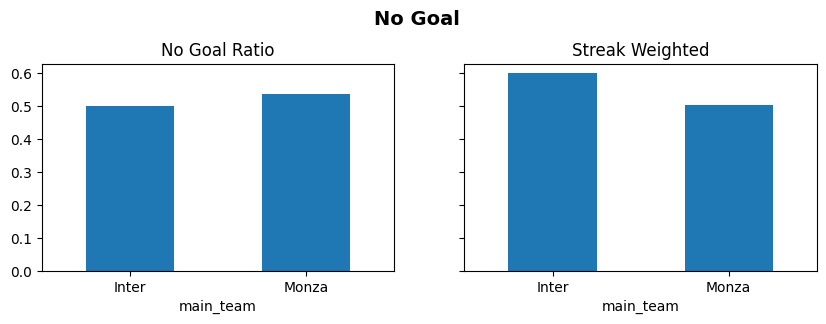

In [363]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
plt.subplots_adjust(hspace=0.6, wspace=0.2)
fig.suptitle(f"No Goal", fontsize=14, fontweight='bold')
plt.subplots_adjust(top=0.8)

ng[['main_team','no_goal_ratio']].set_index('main_team').plot(kind='bar',rot=0, title='No Goal Ratio', ax=axes[0])
ng[['main_team','no_goal_streak_weighted_ratio']].set_index('main_team').plot(kind='bar',rot=0, title='Streak Weighted', ax=axes[1])

[ax.legend().set_visible(False) for ax in axes]
plt.show()

### No Goal - Group

In [364]:
ngg = pd.concat([no_goal_group[(no_goal_group.main_team == home_team)\
                        &(no_goal_group.competition==competition)\
                        &(no_goal_group.team_group==away_team_group)],\
           no_goal_group[(no_goal_group.main_team == away_team)\
                        &(no_goal_group.competition==competition)\
                        &(no_goal_group.team_group==home_team_group)]])

In [365]:
ngg[['main_team','n_matches']].set_index('main_team')

,n_matches
main_team,
Inter,10
Monza,10


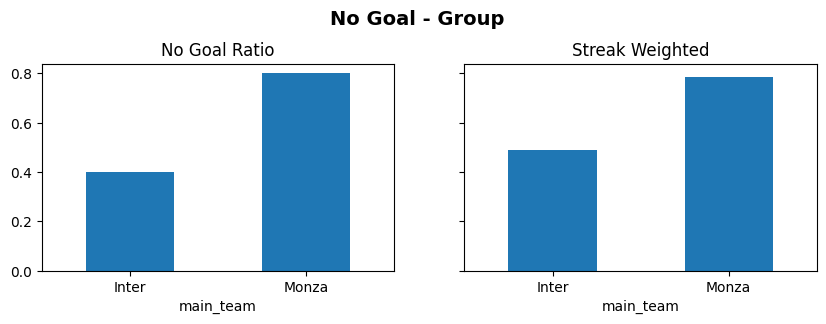

In [366]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
plt.subplots_adjust(hspace=0.6, wspace=0.2)
fig.suptitle(f"No Goal - Group", fontsize=14, fontweight='bold')
plt.subplots_adjust(top=0.8)

ngg[['main_team','no_goal_ratio']].set_index('main_team').plot(kind='bar',rot=0, title='No Goal Ratio', ax=axes[0])
ngg[['main_team','no_goal_streak_weighted_ratio']].set_index('main_team').plot(kind='bar',rot=0, title='Streak Weighted', ax=axes[1])

[ax.legend().set_visible(False) for ax in axes]
plt.show()

### No Goal - Group - Home/Away

In [367]:
nggah = pd.concat([no_goal_group_away_home[(no_goal_group_away_home.main_team == home_team)\
                        &(no_goal_group_away_home.competition==competition)\
                        &(no_goal_group_away_home.away_home=='home')\
                        &(no_goal_group_away_home.team_group==away_team_group)],\
           no_goal_group_away_home[(no_goal_group_away_home.main_team == away_team)\
                        &(no_goal_group_away_home.competition==competition)\
                        &(no_goal_group_away_home.away_home=='away')\
                        &(no_goal_group_away_home.team_group==home_team_group)]])

In [368]:
nggah[['main_team','n_matches']].set_index('main_team')

,n_matches
main_team,
Inter,5
Monza,5


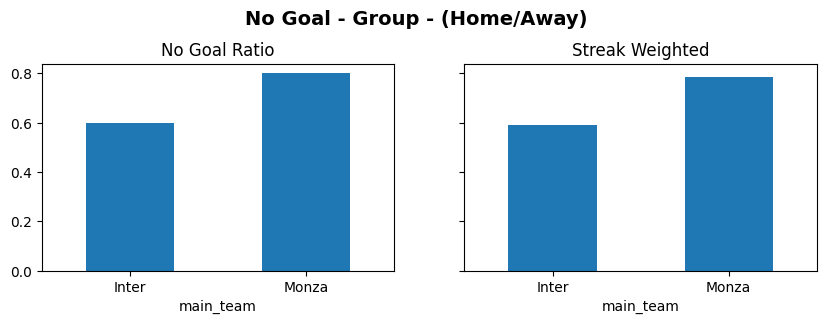

In [369]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
plt.subplots_adjust(hspace=0.6, wspace=0.2)
fig.suptitle(f"No Goal - Group - (Home/Away)", fontsize=14, fontweight='bold')
plt.subplots_adjust(top=0.8)

nggah[['main_team','no_goal_ratio']].set_index('main_team').plot(kind='bar',rot=0, title='No Goal Ratio', ax=axes[0])
nggah[['main_team','no_goal_streak_weighted_ratio']].set_index('main_team').plot(kind='bar',rot=0, title='Streak Weighted', ax=axes[1])

[ax.legend().set_visible(False) for ax in axes]
plt.show()

### Has Scored - Group

In [370]:
scgg = pd.concat([scored_conceded_goal_group[(scored_conceded_goal_group.main_team == home_team)\
                        &(scored_conceded_goal_group.competition==competition)\
                        &(scored_conceded_goal_group.team_group.isin([away_team_group]))],\
           scored_conceded_goal_group[(scored_conceded_goal_group.main_team == away_team)\
                        &(scored_conceded_goal_group.competition==competition)\
                        &(scored_conceded_goal_group.team_group.isin([home_team_group]))]])

In [371]:
scgg[['main_team','n_matches']].set_index('main_team')

,n_matches
main_team,
Inter,10
Monza,10


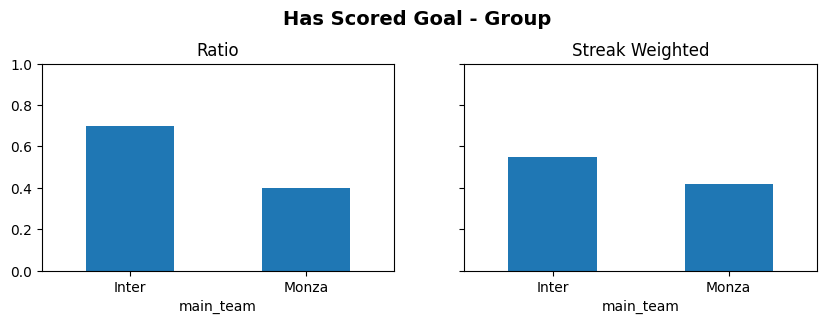

In [372]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
plt.subplots_adjust(hspace=0.6, wspace=0.2)
fig.suptitle(f"Has Scored Goal - Group", fontsize=14, fontweight='bold')
plt.subplots_adjust(top=0.8)

scgg[['main_team','team_has_scored_ratio']].set_index('main_team').plot(kind='bar',rot=0, ylim=(0,1), title='Ratio', ax=axes[0])
scgg[['main_team','team_has_scored_streak_weighted_ratio']].set_index('main_team').plot(kind='bar',rot=0, ylim=(0,1), title='Streak Weighted', ax=axes[1])

[ax.legend().set_visible(False) for ax in axes]
plt.show()

### Has Conceded - Group

In [373]:
scgg[['main_team','n_matches']].set_index('main_team')

,n_matches
main_team,
Inter,10
Monza,10


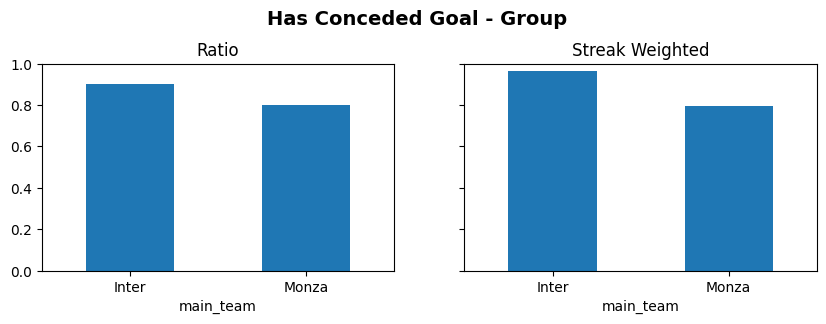

In [374]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
plt.subplots_adjust(hspace=0.6, wspace=0.2)
fig.suptitle(f"Has Conceded Goal - Group", fontsize=14, fontweight='bold')
plt.subplots_adjust(top=0.8)

scgg[['main_team','team_has_conceded_goal_ratio']].set_index('main_team').plot(kind='bar',rot=0, ylim=(0,1), title='Ratio', ax=axes[0])
scgg[['main_team','team_has_conceded_goal_streak_weighted_ratio']].set_index('main_team').plot(kind='bar',rot=0, ylim=(0,1), title='Streak Weighted', ax=axes[1])

[ax.legend().set_visible(False) for ax in axes]
plt.show()

### Wins/Draws/Loss

In [375]:
wdl = pd.concat([win_draw_loss[(win_draw_loss.main_team == home_team)\
                        &(win_draw_loss.competition==competition)\
                        &(win_draw_loss.team_group.isin(['all']))],\
           win_draw_loss[(win_draw_loss.main_team == away_team)\
                        &(win_draw_loss.competition==competition)\
                        &(win_draw_loss.team_group.isin(['all']))]])

In [376]:
wdlg = pd.concat([win_draw_loss[(win_draw_loss.main_team == home_team)\
                        &(win_draw_loss.competition==competition)\
                        &(win_draw_loss.team_group==str(away_team_group))],\
           win_draw_loss[(win_draw_loss.main_team == away_team)\
                        &(win_draw_loss.competition==competition)\
                        &(win_draw_loss.team_group==str(home_team_group))]])
wdlg

,main_team,team_group,competition,n_matches,avg_win,avg_draw,avg_loss,win_streak_weighted,draw_streak_weighted,loss_streak_weighted,tot_giornata,win_streak_weighted_ratio,draw_streak_weighted_ratio,loss_streak_weighted_ratio
137,Inter,1,Serie A,10,0.5,0.1,0.4,63.0,17.0,78.0,158.0,0.398734,0.107595,0.493671
192,Monza,0,Serie A,10,0.2,0.1,0.7,27.0,17.0,87.0,131.0,0.206107,0.129771,0.664122


In [377]:
wdlgah = pd.concat([win_draw_loss_away_home[(win_draw_loss_away_home.main_team == home_team)\
                        &(win_draw_loss_away_home.competition==competition)\
                        &(win_draw_loss_away_home.away_home=='home')\
                        &(win_draw_loss_away_home.team_group.apply(str)==str(away_team_group))],\
           win_draw_loss_away_home[(win_draw_loss_away_home.main_team == away_team)\
                        &(win_draw_loss_away_home.away_home=='away')\
                        &(win_draw_loss_away_home.competition==competition)\
                        &(win_draw_loss_away_home.team_group.apply(str)==str(home_team_group))]])
wdlgah

,main_team,team_group,competition,away_home,n_matches,avg_win,avg_draw,avg_loss,win_streak_weighted,draw_streak_weighted,loss_streak_weighted,tot_giornata,win_streak_weighted_ratio,draw_streak_weighted_ratio,loss_streak_weighted_ratio
275,Inter,1,Serie A,home,5,0.6,0.0,0.4,43.0,0.0,47.0,90.0,0.477778,0.0,0.522222
384,Monza,0,Serie A,away,5,0.2,0.0,0.8,20.0,0.0,31.0,51.0,0.392157,0.0,0.607843


#### Wins Overall

In [378]:
wdl[['main_team','n_matches']].set_index('main_team')

,n_matches
main_team,
Inter,28
Monza,28


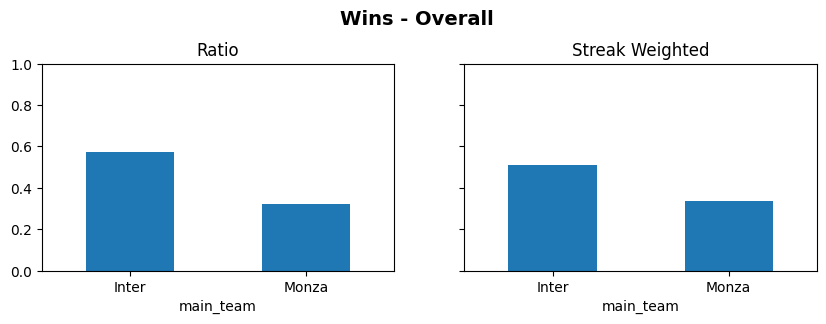

In [379]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
plt.subplots_adjust(hspace=0.6, wspace=0.2)
fig.suptitle(f"Wins - Overall", fontsize=14, fontweight='bold')
plt.subplots_adjust(top=0.8)

wdl[['main_team','avg_win']].set_index('main_team').plot(kind='bar',rot=0, ylim=(0,1), title='Ratio', ax=axes[0])
wdl[['main_team','win_streak_weighted_ratio']].set_index('main_team').plot(kind='bar',rot=0, ylim=(0,1), title='Streak Weighted', ax=axes[1])

[ax.legend().set_visible(False) for ax in axes]
plt.show()

#### Wins VS Group

In [380]:
wdlg[['main_team','n_matches']].set_index('main_team')

,n_matches
main_team,
Inter,10
Monza,10


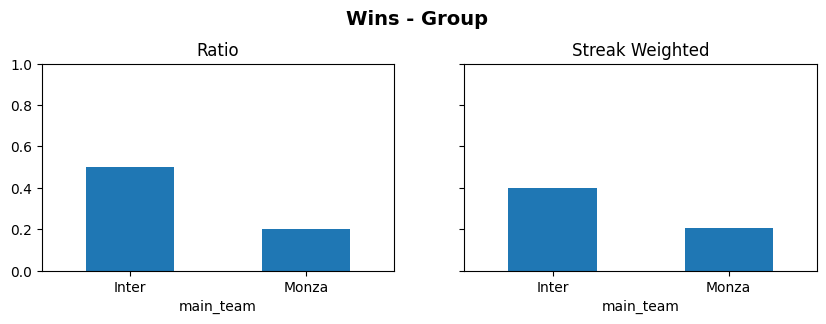

In [381]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
plt.subplots_adjust(hspace=0.6, wspace=0.2)
fig.suptitle(f"Wins - Group", fontsize=14, fontweight='bold')
plt.subplots_adjust(top=0.8)

wdlg[['main_team','avg_win']].set_index('main_team').plot(kind='bar',rot=0, ylim=(0,1), title='Ratio', ax=axes[0])
wdlg[['main_team','win_streak_weighted_ratio']].set_index('main_team').plot(kind='bar',rot=0, ylim=(0,1), title='Streak Weighted', ax=axes[1])

[ax.legend().set_visible(False) for ax in axes]
plt.show()

#### Wins - Group - Home/Away

In [382]:
wdlgah[['main_team','n_matches']].set_index('main_team')

,n_matches
main_team,
Inter,5
Monza,5


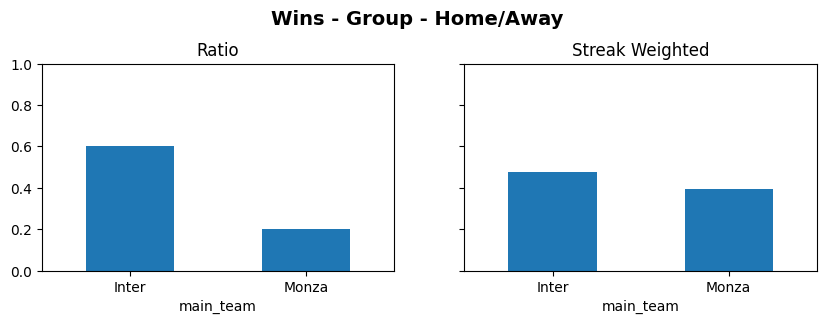

In [383]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
plt.subplots_adjust(hspace=0.6, wspace=0.2)
fig.suptitle(f"Wins - Group - Home/Away", fontsize=14, fontweight='bold')
plt.subplots_adjust(top=0.8)

wdlgah[['main_team','avg_win']].set_index('main_team').plot(kind='bar',rot=0, ylim=(0,1), title='Ratio', ax=axes[0])
wdlgah[['main_team','win_streak_weighted_ratio']].set_index('main_team').plot(kind='bar',rot=0, ylim=(0,1), title='Streak Weighted', ax=axes[1])

[ax.legend().set_visible(False) for ax in axes]
plt.show()

#### Draws - Group

In [384]:
wdlgah[['main_team','n_matches']].set_index('main_team')

,n_matches
main_team,
Inter,5
Monza,5


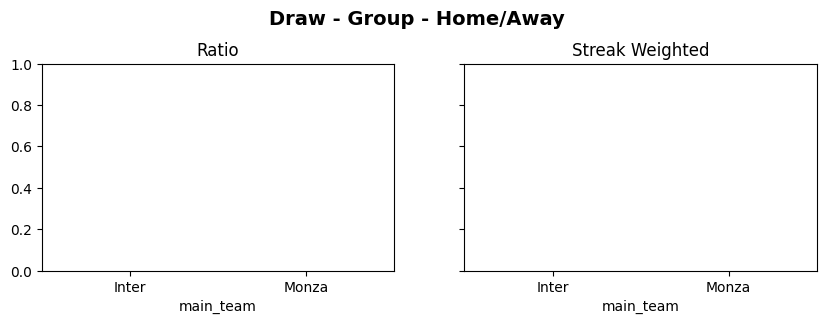

In [385]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
plt.subplots_adjust(hspace=0.6, wspace=0.2)
fig.suptitle(f"Draw - Group - Home/Away", fontsize=14, fontweight='bold')
plt.subplots_adjust(top=0.8)

wdlgah[['main_team','avg_draw']].set_index('main_team').plot(kind='bar',rot=0, title='Ratio', ylim=(0,1), ax=axes[0])
wdlgah[['main_team','draw_streak_weighted_ratio']].set_index('main_team').plot(kind='bar',rot=0, ylim=(0,1), title='Streak Weighted', ax=axes[1])

[ax.legend().set_visible(False) for ax in axes]
plt.show()

#### Loss - Group

In [386]:
wdlg[['main_team','n_matches']].set_index('main_team')

,n_matches
main_team,
Inter,10
Monza,10


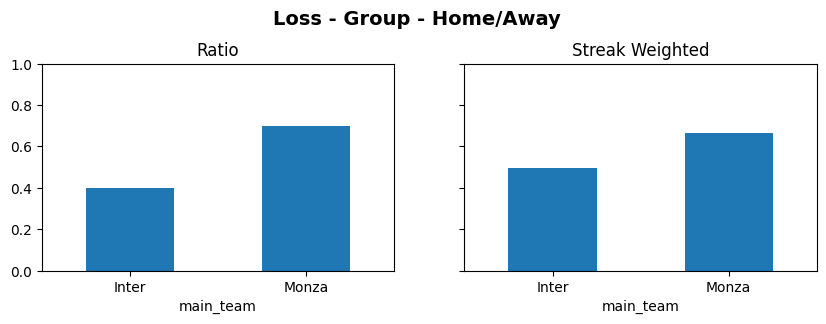

In [387]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
plt.subplots_adjust(hspace=0.6, wspace=0.2)
fig.suptitle(f"Loss - Group - Home/Away", fontsize=14, fontweight='bold')
plt.subplots_adjust(top=0.8)

wdlg[['main_team','avg_loss']].set_index('main_team').plot(kind='bar',rot=0, title='Ratio', ylim=(0,1), ax=axes[0])
wdlg[['main_team','loss_streak_weighted_ratio']].set_index('main_team').plot(kind='bar',rot=0, ylim=(0,1), title='Streak Weighted', ax=axes[1])

[ax.legend().set_visible(False) for ax in axes]
plt.show()

In [388]:
matches_df[(matches_df.main_team==home_team)]\
        .sort_values('giornata')\
        [['main_team','opponent_team','away_home','result',
          'giornata','team_group','team_has_conceded_goal']]

,main_team,opponent_team,away_home,result,giornata,team_group,team_has_conceded_goal
5655,Inter,Lecce,away,Win,1.0,2,True
256,Inter,Spezia,home,Win,2.0,2,False
6021,Inter,Lazio,away,Loss,3.0,0,True
638,Inter,Cremonese,home,Win,4.0,2,True
6423,Inter,Milan,away,Loss,5.0,0,True
1030,Inter,Torino,home,Win,6.0,1,False
6889,Inter,Udinese,away,Loss,7.0,1,True
1422,Inter,Roma,home,Loss,8.0,0,True
7211,Inter,Sassuolo,away,Win,9.0,1,True
1874,Inter,Salernitana,home,Win,10.0,2,False
